In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [29]:
import keras

from keras.models import Model
from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, UpSampling2D

print(keras.__version__)

1.2.1


In [30]:
(x_train, _), (x_test, _) = mnist.load_data()

In [31]:
# normalize train data
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
print(x_train.shape)

(60000, 28, 28, 1)


In [32]:
# normalize test data (which serves as our labels)
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_test.shape)

(10000, 28, 28, 1)


In [33]:
# create noisy data for train and test
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [34]:
# renormalize through clipping
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [35]:
# create the encode network
input_img = Input(shape=(28,28,1))
x = Convolution2D(32,3,3,activation='relu',border_mode='same')(input_img)
x = MaxPooling2D((2,2),border_mode='same')(x)
x = Convolution2D(32,3,3,activation='relu',border_mode='same')(x)
encoded = MaxPooling2D((2,2),border_mode='same')(x)
# 7,7,32

In [36]:
# create the decode network
x = Convolution2D(32,3,3,activation='relu',border_mode='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Convolution2D(32,3,3,activation='relu',border_mode='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Convolution2D(1,3,3,activation='sigmoid',border_mode='same')(x)
#back to 28,28,1

In [37]:
# create the autoencoder by tying the encode and decode networks together
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 28, 28, 32)    320         input_3[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 14, 14, 32)    0           convolution2d_11[0][0]           
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 14, 14, 32)    9248        maxpooling2d_5[0][0]             
___________________________________________________________________________________________

In [38]:
# train
autoencoder.fit(x_train_noisy, x_train,
  nb_epoch=10,
  batch_size=256,
  shuffle=True,
  validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 176s - loss: 0.2000 - val_loss: 0.1297

In [40]:
# create the encoder model
encoder = Model(input=input_img, output=encoded)
encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 28, 28, 32)    320         input_3[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 14, 14, 32)    0           convolution2d_11[0][0]           
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 14, 14, 32)    9248        maxpooling2d_5[0][0]             
___________________________________________________________________________________________

In [42]:
# create the decoder model
encoded_input = Input(shape=(7,7,32))

# this is pretty ugly. is there a better way? like layer.pop?
decoder1 = autoencoder.layers[-5]
decoder2 = autoencoder.layers[-4]
decoder3 = autoencoder.layers[-3]
decoder4 = autoencoder.layers[-2]
decoder5 = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder5(decoder4(decoder3(decoder2(decoder1(encoded_input))))))
decoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 7, 7, 32)      0                                            
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 7, 7, 32)      9248        input_5[0][0]                    
____________________________________________________________________________________________________
upsampling2d_5 (UpSampling2D)    (None, 14, 14, 32)    0           convolution2d_13[1][0]           
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 14, 14, 32)    9248        upsampling2d_5[1][0]             
___________________________________________________________________________________________

In [43]:
# run noisy test data through the encoder
encoded_imgs = encoder.predict(x_test_noisy)

# run encoded noisy test image back through the decoder
decoded_imgs = decoder.predict(encoded_imgs)

# make sense of the shapes
print(encoded_imgs.shape)
print(decoded_imgs.shape)

(10000, 7, 7, 32)
(10000, 28, 28, 1)


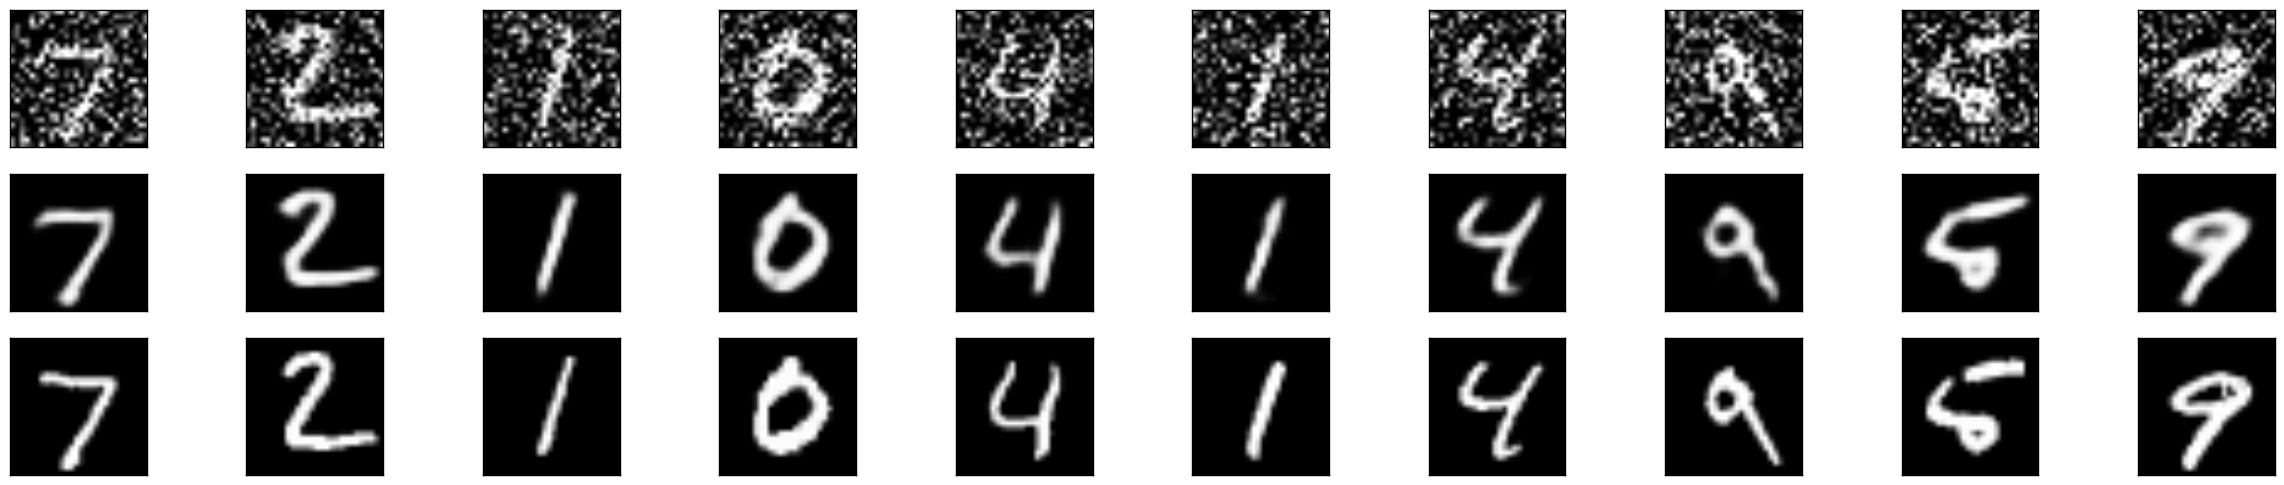

In [46]:
# display the images
n = 10
plt.figure(figsize=(30,6))
for i in range(n):
  # noisy images
  ax = plt.subplot(3,n,i+1)
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # denoised images
  ax = plt.subplot(3,n,i+1+n)
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # original images
  ax = plt.subplot(3,n,i+1+n*2)
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()